# Multi Agent Collaboration

### Individual Agents Working Together

We've seen the Agent/Supervisor setup, but this time we'll have independent agents, each with their own tools pass work off between themselves.

The differences now is that any of them can determine whether the job is finished, not just a single supervisor

## The Framework

![x](diagrammulti.png)

#### Three Agents Collaborating
1. **Weather Agent** - Has access to real time weather reporting tool
2. **Events Agent** - Has access to real time event reporting tool
3. **Web Search Agent** - Has access to web search tool

The work is passed between them, following the flow of **Weather Agent** -> **Events Agent** -> **Web Search Agent** -> Repeat until one of the agents determines the task is completed.

A Central Routing function handles all the logic very simply. If an agent calls a tool, it goes to the tool invocation node which routes the context back to the agent that called the tool. If an agent returns **FINAL ANSWER**, it ends the loop.

---

# Environment Setup

In [1]:
# Dependencies
import os
import datetime
import requests
import functools
import operator
from typing import Annotated, Sequence, TypedDict, Literal
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import BaseTool, StructuredTool, tool
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_core.messages import (
    BaseMessage,
    ToolMessage,
    HumanMessage,
    AIMessage
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode

# LangSmith Tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Collab Project"

In [19]:
# API Keys for OpenWeatherMap and TicketMaster API
ow_api_key = ""
tm_api_key = ""

---

# Tools

Importing and creating the tools to be used by their respective agents

### Weather Tool Function Setup using OpenWeatherMap

https://openweathermap.org/api

In [15]:
# Function for finding Latitude and Longitude of a city
def get_lat_lon(city, state, api_key):
    base_url = "http://api.openweathermap.org/geo/1.0/direct"
    params = {
        'q': f"{city},{state},US",
        'limit': 1,
        'appid': api_key
    }
    
    response = requests.get(base_url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        if data:
            lat = data[0]['lat']
            lon = data[0]['lon']
            return lat, lon
        else:
            return None, None
    else:
        return None, None

# Function to return the raw data from OpenWeatherMap
def get_weather_data(lat, lon, api_key):
    base_url = "http://api.openweathermap.org/data/2.5/forecast"
    params = {
        'lat': lat,
        'lon': lon,
        'appid': api_key,
        'units': 'imperial'
    }
    
    response = requests.get(base_url, params=params)
    
    if response.status_code == 200:
        return response.json()
    else:
        return f"Error: {response.status_code}"

# Function to Parse & Format Relevant Data from OpenWeatherMap
def parse_weather_data(weather_data):
    parsed_data = []

    for entry in weather_data['list']:
        dt = entry['dt_txt']
        main = entry['main']
        weather = entry['weather'][0]
        date_time = datetime.datetime.strptime(dt, "%Y-%m-%d %H:%M:%S")

        day_data = {
            'date': date_time.strftime("%Y-%m-%d"),
            'time': date_time.strftime("%H:%M:%S"),
            'temp_min': main['temp_min'],
            'temp_max': main['temp_max'],
            'feels_like': main['feels_like'],
            'weather': weather['description'],
            'humidity': main['humidity']
        }

        parsed_data.append(day_data)

    return parsed_data

# Example usage
city = "San Francisco"
state = "CA"
lat, lon = get_lat_lon(city, state, ow_api_key)

if lat is not None and lon is not None:
    weather_data = get_weather_data(lat, lon, ow_api_key)
    parsed_data = parse_weather_data(weather_data)
    for data in parsed_data:
        print(data)
else:
    print("Could not find the latitude and longitude for the specified city and state.")    

{'date': '2024-05-30', 'time': '00:00:00', 'temp_min': 62.44, 'temp_max': 68.2, 'feels_like': 67.26, 'weather': 'clear sky', 'humidity': 54}
{'date': '2024-05-30', 'time': '03:00:00', 'temp_min': 58.78, 'temp_max': 62.89, 'feels_like': 61.84, 'weather': 'clear sky', 'humidity': 63}
{'date': '2024-05-30', 'time': '06:00:00', 'temp_min': 55.71, 'temp_max': 55.71, 'feels_like': 54.55, 'weather': 'clear sky', 'humidity': 76}
{'date': '2024-05-30', 'time': '09:00:00', 'temp_min': 54.45, 'temp_max': 54.45, 'feels_like': 53.35, 'weather': 'clear sky', 'humidity': 80}
{'date': '2024-05-30', 'time': '12:00:00', 'temp_min': 53.15, 'temp_max': 53.15, 'feels_like': 52.07, 'weather': 'clear sky', 'humidity': 83}
{'date': '2024-05-30', 'time': '15:00:00', 'temp_min': 55.67, 'temp_max': 55.67, 'feels_like': 54.41, 'weather': 'clear sky', 'humidity': 74}
{'date': '2024-05-30', 'time': '18:00:00', 'temp_min': 60.48, 'temp_max': 60.48, 'feels_like': 59.18, 'weather': 'clear sky', 'humidity': 63}
{'date'

### Event Tool Function Setup using TicketMaster API

https://developer.ticketmaster.com/products-and-docs/apis/discovery-api/v2/

In [16]:
# Function to find 50 events in a 25 mile radius to the latitude and longitude
def find_events(lat, lon, radius, api_key, size=50):
    base_url = "https://app.ticketmaster.com/discovery/v2/events.json"
    params = {
        'apikey': api_key,
        'latlong': f"{lat},{lon}",
        'radius': radius,
        'unit': 'miles',
        'sort': 'date,asc',  # Sort by date in ascending order
        'size': size  # Set the page size to the desired number of results
    }
    
    response = requests.get(base_url, params=params)
    
    if response.status_code == 200:
        return response.json()
    else:
        return None

# Function to parse the event data into just useful info
def parse_event_data(event_data):
    if '_embedded' not in event_data:
        return "No events found."
    
    events = event_data['_embedded']['events']
    parsed_events = []
    
    for event in events:
        event_info = {
            'name': event['name'],
            'date': event['dates']['start']['localDate'],
            # 'time': event['dates']['start']['localTime'],
            'venue': event['_embedded']['venues'][0]['name'],
            'city': event['_embedded']['venues'][0]['city']['name']
        }
        parsed_events.append(event_info)
    
    return parsed_events

# Example usage
lat, lon = get_lat_lon(city, state, ow_api_key)
radius = 25
event_data = find_events(lat, lon, radius, tm_api_key)

if event_data:
    parsed_events = parse_event_data(event_data)
    for event in parsed_events:
        print(event)
else:
    print("Failed to retrieve event data.")

{'name': 'Roast Battle Bay Area', 'date': '2024-05-29', 'venue': "Cobb's Comedy Club", 'city': 'San Francisco'}
{'name': 'Maren Morris - RSVP Redux Tour', 'date': '2024-05-29', 'venue': 'The Masonic', 'city': 'San Francisco'}
{'name': 'Psychedelic Porn Crumpets', 'date': '2024-05-29', 'venue': 'The Independent', 'city': 'San Francisco'}
{'name': 'Psychedelic Porn Crumpets', 'date': '2024-05-29', 'venue': 'The Independent', 'city': 'San Francisco'}
{'name': 'Mark Smalls', 'date': '2024-05-29', 'venue': 'Punch Line Comedy Club - San Francisco', 'city': 'San Francisco'}
{'name': 'Son Rompe Pera, Gina Madrid, DJ Hella Breezy', 'date': '2024-05-29', 'venue': 'The New Parish', 'city': 'Oakland'}
{'name': 'Jon B.', 'date': '2024-05-29', 'venue': "Yoshi's", 'city': 'Oakland'}
{'name': 'Jon B.', 'date': '2024-05-29', 'venue': "Yoshi's", 'city': 'Oakland'}
{'name': 'Sarah McLachlan - Fumbling Towards Ecstasy 30th Anniversary Tour', 'date': '2024-05-30', 'venue': 'Greek Theatre-U.C. Berkeley', 'c

### Formatting the Tools

We do two things here, first is importing a premade tool from langchain **DuckDuckGoSearch**

https://python.langchain.com/v0.1/docs/integrations/tools/ddg/

Secondly, we are defining our own **Custom Tools** using the above functions and Pydantic for Schemas

https://python.langchain.com/v0.1/docs/modules/tools/custom_tools/

In [5]:
# DDG Web Search Tool
search_wrapper = DuckDuckGoSearchAPIWrapper(max_results=15)
web_search = DuckDuckGoSearchRun(api_wrapper=search_wrapper)

# Weather Search Tool Schema
class WeatherInput(BaseModel):
    city: str = Field(description="city name, e.g. Durham, San Francisco, Newark")
    state: str = Field(description="state abbreviation, e.g. 'NC', 'NJ', 'IL'")

# Weather Search Tool
@tool("weather_lookup", args_schema=WeatherInput)
def weather_lookup(city: str, state: str) -> list:
    """Use this tool to get accuracte weather forecasts for a city"""
    global ow_api_key
    lat, lon = get_lat_lon(city, state, api_key=ow_api_key)
    weather_data = get_weather_data(lat, lon, api_key=ow_api_key)
    parsed_data = parse_weather_data(weather_data)
    return parsed_data

# Event Search Tool Schema
class EventInput(BaseModel):
    city: str = Field(description="city name, e.g. Durham, San Francisco, Newark")
    state: str = Field(description="state abbreviation, e.g. 'NC', 'NJ', 'IL'")

# Event Search Tool
@tool("event_lookup", args_schema=EventInput)
def event_lookup(city: str, state: str) -> list:
    """Use this tool to get accurate data for upcoming events for a city"""
    global ow_api_key
    global tm_api_key
    lat, lon = get_lat_lon(city, state, api_key=ow_api_key)
    event_data = find_events(lat, lon, radius=25, api_key=tm_api_key)
    parsed_events = parse_event_data(event_data)
    return parsed_events

---
# Setting Up The Agents

Code here is heavily pulled from LangChain's documentation on Multi Agent Collaboration

https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/multi-agent-collaboration.ipynb

### Helper Functions

In [6]:
# Create Agents Helper Function - Will allow us to create our three agents quickly 
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have all the information to answer the user's query,"
                " prefix your response with FINAL ANSWER so the team knows to stop. And generate"
                " a comprehensive markdown report containing all relevant information for the user question."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [7]:
# Helper function to create a LangGraph node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # Converting the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        "sender": name,
    }

### LangGraph State

Tracks the information passed around the LangGraph Setup

In [8]:
# Define State for LangGraph Implementation - Essentially keeps track of messages between the agents and who the last one is coming from
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

### Agent & Node Setup

Using the helper functions created above, defining the three agents of interest
1. **Weather Agent**
2. **Events Agent**
3. **Web Search Agent**

In [9]:
llm = ChatOpenAI(model="gpt-3.5-turbo")

# Weather agent and node
weather_agent = create_agent(
    llm,
    [weather_lookup],
    system_message="You should provide accurate weather data for the other agents to use. When you have provided weather details, pass along the work."
)
weather_node = functools.partial(agent_node, agent=weather_agent, name="weather_agent")

# Events agent and node
events_agent = create_agent(
    llm,
    [event_lookup],
    system_message="You should provide accurate events data for the other agents to use. When you have provided event details, pass along the work."
)
events_node = functools.partial(agent_node, agent=events_agent, name="events_agent")

# Web Search agent and node
websearch_agent = create_agent(
    llm,
    [web_search],
    system_message="You can use the provided web search tool to give accurate search result data for the team to use if needed."
)
websearch_node = functools.partial(agent_node, agent=websearch_agent, name="websearch_agent")

### Tool Node

This class receives the list of messages (containing [tool_calls](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.ai.AIMessage.html#langchain_core.messages.ai.AIMessage.tool_calls), calls the tool(s) the LLM has requested to run, and returns the output as new [ToolMessage(s)](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.tool.ToolMessage.html#langchain_core.messages.tool.ToolMessage).

In [10]:
# Define Tool Node
tools = [weather_lookup, event_lookup, web_search]
tool_node = ToolNode(tools)

---

# Building the LangGraph Graph

### Main Router Logic

Simply routes tool calls to the tool node and returns results to the agent, and passes one agent's work to the next

**Important Note** Since this is multi-agent collaboration, any agent can decide to end with the final answer

In [11]:
# Router Function
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

### Compiling the nodes and edges

In [12]:
workflow = StateGraph(AgentState)

workflow.add_node("weather_agent", weather_node)
workflow.add_node("events_agent", events_node)
workflow.add_node("websearch_agent", websearch_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "weather_agent",
    router,
    {"continue": "events_agent", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "events_agent",
    router,
    {"continue": "websearch_agent", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "websearch_agent",
    router,
    {"continue": "weather_agent", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "weather_agent": "weather_agent",
        "events_agent": "events_agent",
        "websearch_agent": "websearch_agent",
    },
)
workflow.set_entry_point("weather_agent")
graph = workflow.compile()

### Another Visualization of the Graph

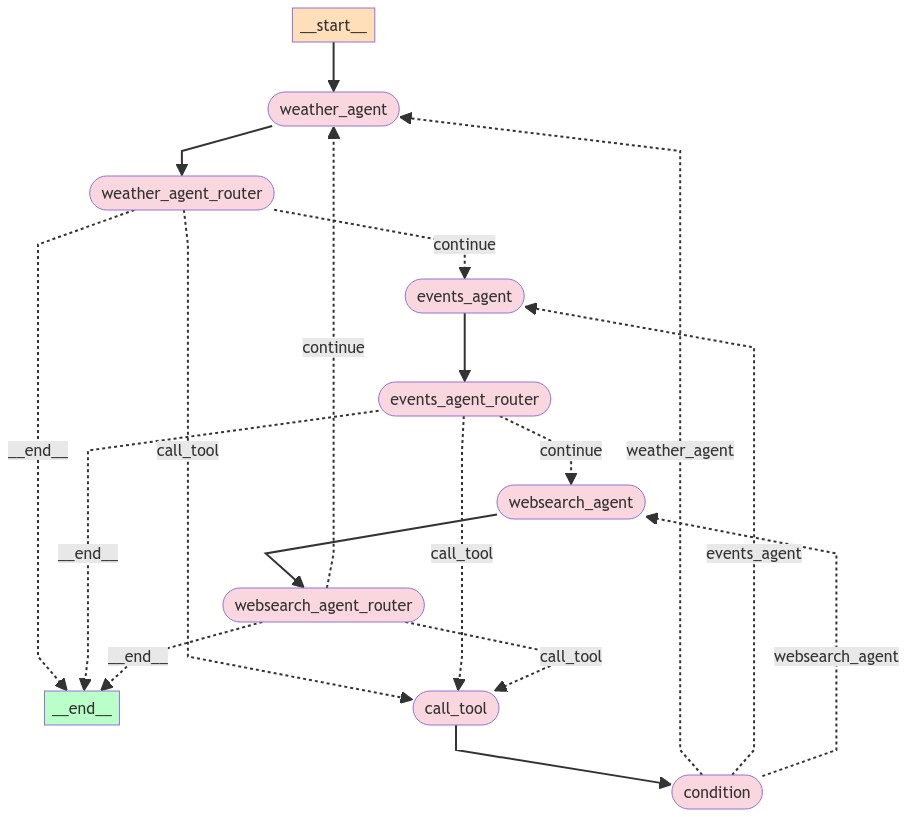

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

---
# Invoking the Agent!

In [18]:
from IPython.display import display, Markdown

# Streaming the LangGraph Outputs
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="What's the weather, and what fun events are currently happening in Denver Colorado this weekend June 1st-3rd? Also, can you search where is good parking?"
            )
        ],
    },
    {"recursion_limit": 150},
)

# Printing the final answer nicely
final_answer = None
for s in events:
    print(s)
    print("----")
    for agent, data in s.items():
        if 'messages' in data:
            for message in data['messages']:
                if 'FINAL ANSWER' in message.content:
                    final_answer = message.content

if final_answer:
    print("====================")
    display(Markdown(final_answer))


{'weather_agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_F69Al7jxOeAakt3MNTo3DRVo', 'function': {'arguments': '{"city":"Denver","state":"CO"}', 'name': 'weather_lookup'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 275, 'total_tokens': 293}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, name='weather_agent', id='run-dfcdc458-1259-4ddb-aca1-c5083fb62694-0', tool_calls=[{'name': 'weather_lookup', 'args': {'city': 'Denver', 'state': 'CO'}, 'id': 'call_F69Al7jxOeAakt3MNTo3DRVo'}])], 'sender': 'weather_agent'}}
----
{'call_tool': {'messages': [ToolMessage(content='[{"date": "2024-05-30", "time": "00:00:00", "temp_min": 71.46, "temp_max": 78.78, "feels_like": 78.78, "weather": "light rain", "humidity": 25}, {"date": "2024-05-30", "time": "03:00:00", "temp_min": 70.7, "temp_max": 74.62, "feels_like": 73.06, "weather": "broken clouds

FINAL ANSWER

### Weather Forecast for Denver, Colorado:
- **June 1st:**
  - Max Temperature: 85.17°F, Min Temperature: 58.33°F
  - Weather: Broken clouds

- **June 2nd:**
  - Max Temperature: 87.12°F, Min Temperature: 60.55°F
  - Weather: Clear sky

- **June 3rd:**
  - Max Temperature: 89.31°F, Min Temperature: 63.75°F
  - Weather: Clear sky

### Fun Events in Denver, Colorado this Weekend:
- **Friday, May 31st:**
  - Lord Huron at Red Rocks Amphitheatre
  - Company at Buell Theatre
  - Brooks & Dunn: Reboot 2024 Tour at Ball Arena
  - Rainbow Kitten Surprise at Mission Ballroom

- **Saturday, June 1st:**
  - Outside Festival at Civic Center Park
  - Yoga on the Rocks at Red Rocks Amphitheatre
  - Where Did We Sit On The Bus at Singleton Theatre
  - Company at Buell Theatre
  - U.S. Women's National Team v Korea Republic at DICK'S Sporting Goods Park

- **Sunday, June 2nd:**
  - HearseCon 2024 with Morbid Curiosities Carnival at Stampede
  - Rock and Roll Playhouse at Bluebird Theatre

### Parking Options in Denver, Colorado:
- **Coors Field Parking:** Affordable parking options
- **Ball Arena Parking:** Reserve spots in advance, accessible via public transportation
- **Empower Field at Mile High Parking:** Detailed information on official and third-party options
- **Other Parking Tips:** On Air Parking for cheap options, Microtel Inn and Suites for covered and uncovered parking with shuttle services

Enjoy your time in Denver and have a great weekend! If you need further assistance, feel free to ask.

---
# Pros and Cons

### Pros
1. Kinda cool to watch the logic be fully automated and passed around
2. Very Dynamic workflow, can provide interesting and unique results

### Cons
1. Language Models have a hard time figuring out when to invoke their tools
2. Can loop endlessly and get stuck.
3. The output of the tools can get summarized multiple times
4. Not very controllable
5. Not consistently reliable
